# Visualization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

plt.style.use("dark_background")

### Coloring Methods

In [2]:
def get_alpha_blend_cmap(cmap, alpha):
    cls = plt.get_cmap(cmap)(np.linspace(0,1,256))
    cls = (1-alpha) + alpha*cls
    return ListedColormap(cls)

def get_color_palette_from_cmap(cmap_label, cmap_width, range_width, reversed):
    colors = []
    cmap = plt.get_cmap(cmap_label, cmap_width)

    color_range = range(cmap_width - 1, cmap_width - range_width -1, -1) if reversed else range(range_width)
    for i in color_range:
        colors.append(cmap(i))
    return colors

def get_plot_kws(scatter_kws, line_kws):
    return {'line_kws':{'color':line_kws}, 'scatter_kws': {'color': scatter_kws}}

### Read Processed Data

In [3]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv')
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020,16,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021,64,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021,15,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021,2,14976,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021,32,2071,2021-12-01,1989,360000


### Correlation Map

In [92]:
def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    _, _ = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, vmax=.3, cmap=get_alpha_blend_cmap("rocket_r", 0.9), center=0,
                square=True, linewidths=0, cbar_kws={"shrink": .5})

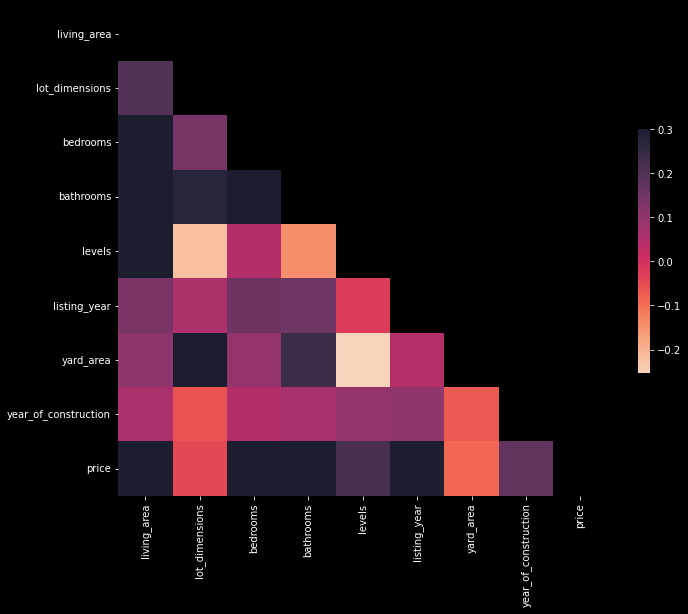

In [93]:
plot_corr_map(listings_df.drop(columns=['age']))

## Price

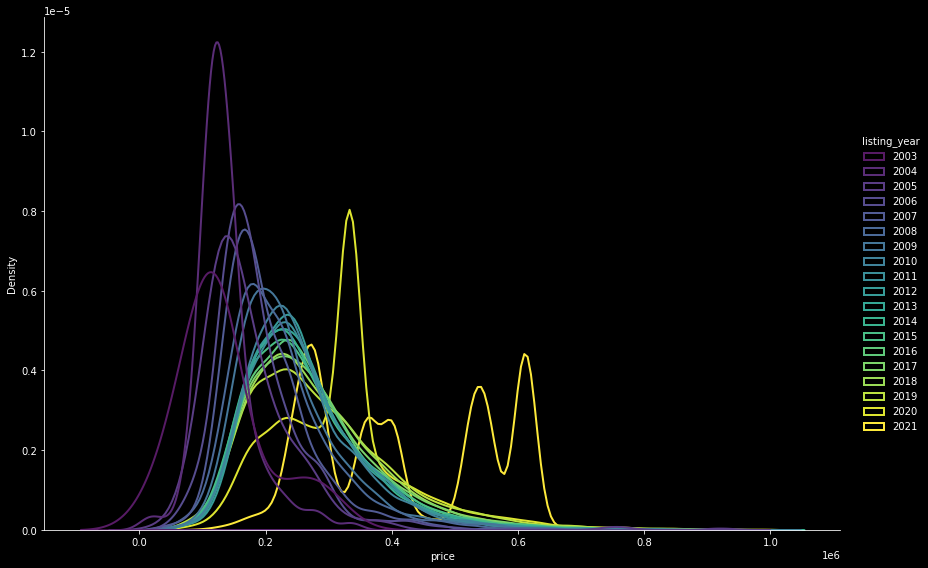

In [94]:
sns.displot(listings_df, x='price', hue='listing_year', kind="kde", fill=True, common_norm=False, height=8, aspect=1.5, alpha=.0, linewidth=2, palette=get_alpha_blend_cmap("viridis", 0.9))

## Listing Year

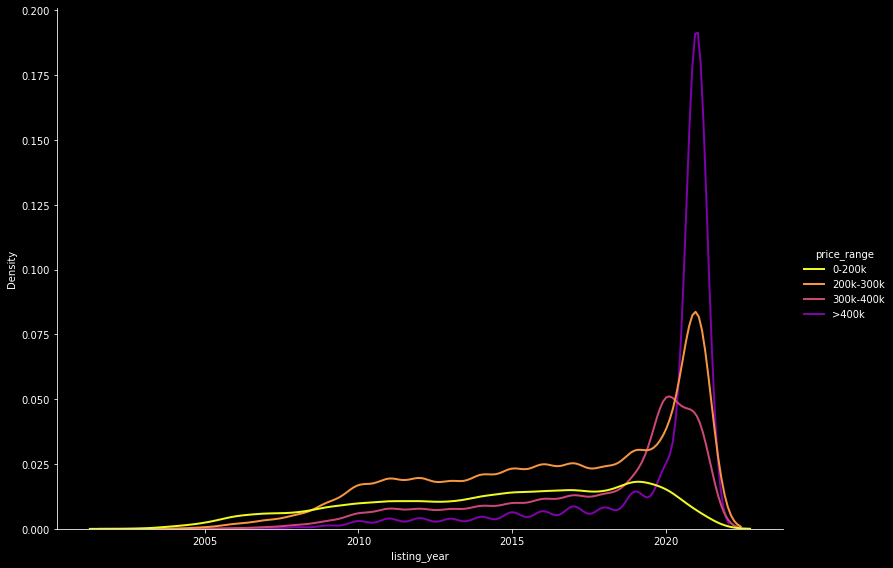

In [95]:
conditions = [(listings_df['price'] >= 0) & (listings_df['price'] < 200000), (listings_df['price'] >= 200000) & (listings_df['price'] < 300000), (listings_df['price'] >= 300000) & (listings_df['price'] < 400000), listings_df['price'] >= 400000]
values = ['0-200k', '200k-300k', '300k-400k', '>400k']

listings_df['price_range'] = np.select(conditions, values, default=0)

sns.displot(listings_df, x='listing_year', hue='price_range', hue_order=values, kind="kde", common_norm=True, height=8, aspect=1.4, linewidth=2, palette=get_color_palette_from_cmap("plasma", 5, 4, True))

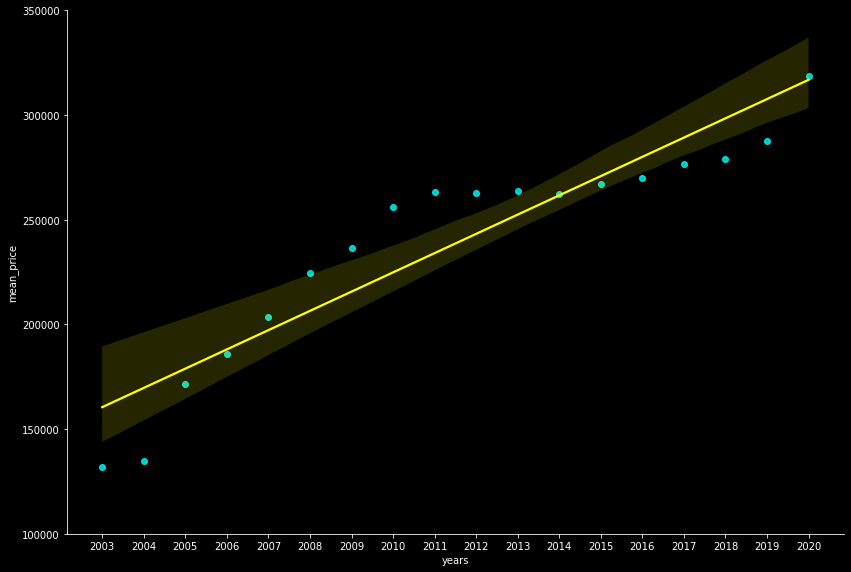

In [96]:
mean_prices = []

min_y = min(listings_df['listing_year'].unique())
max_y = max(listings_df['listing_year'].unique())
years = range(min_y, max_y)

for y in years:
    mean_prices.append(listings_df[listings_df['listing_year'] == y]['price'].mean())

df = pd.DataFrame(list(zip(years, mean_prices)), columns =['years', 'mean_price'])

s = sns.pairplot(data=df, x_vars='years', y_vars='mean_price', kind="reg", height=8, aspect=1.5, plot_kws=get_plot_kws('cyan', 'yellow'))
s.set(xticks=years, yticks=range(100000, 400000, 50000))

## Living Area

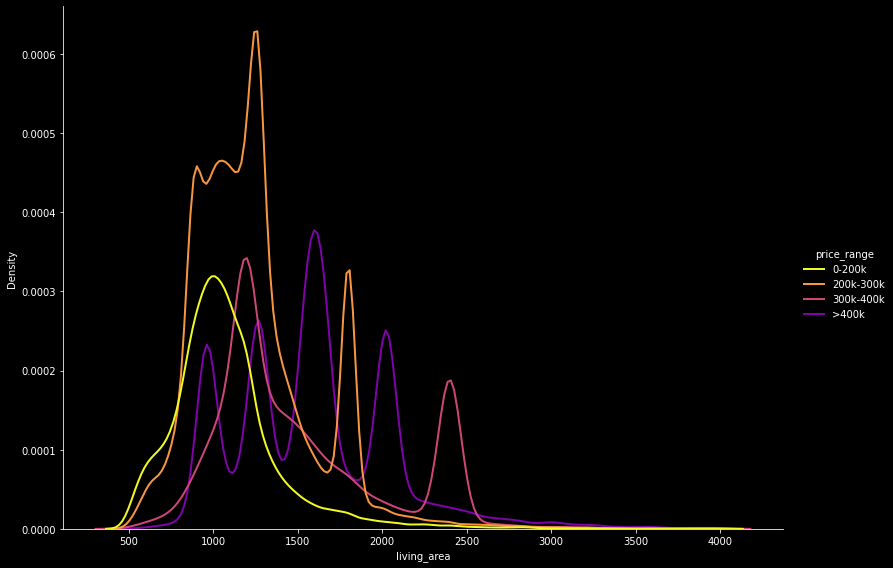

In [97]:
sns.displot(listings_df, x='living_area', hue='price_range', hue_order=values, kind="kde", common_norm=True, height=8, aspect=1.4, linewidth=2, palette=get_color_palette_from_cmap("plasma", 5, 4, True))

In [98]:
listings_df

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price,price_range
0,2 Storey,2 storey,1191,4076,3,1,2,Beauport,2020,16,2885,2020-12-01,2004,332500,300k-400k
1,Bungalow,Open area,1261,9500,2,1,1,Deschambault,2021,64,8239,2021-12-01,1957,265000,200k-300k
2,Townhouse,Unknown,1645,1360,3,1,3,Mercier,2021,15,0,2021-11-01,2006,612000,>400k
3,Bi-generation,Link,2024,17000,4,3,1,Stoneham,2021,2,14976,2021-12-01,2019,526500,>400k
4,Semi-detached,2 storey,2400,4471,4,2,2,Gatineau,2021,32,2071,2021-12-01,1989,360000,300k-400k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127600,Condominium,Cathedral roof,734,7800,1,1,1,Mercier,2004,12,7066,2004-02-01,1992,142000,0-200k
127601,Condominium,Unknown,560,7800,2,1,1,Le Sud-Ouest,2003,83,7240,2003-10-01,1920,80000,0-200k
127602,Condominium,Unknown,560,7800,2,1,1,Le Sud-Ouest,2003,83,7240,2003-10-01,1920,34000,0-200k
127603,Condominium,Unknown,3180,7800,3,2,2,Beauport,2004,12,4620,2004-01-01,1992,128500,0-200k


ConversionError: Failed to convert value(s) to axis units: ['500-1000 sq.ft', '1000-2000 sq.ft', '2000-2500 sq.ft', '>2500 sq.ft']

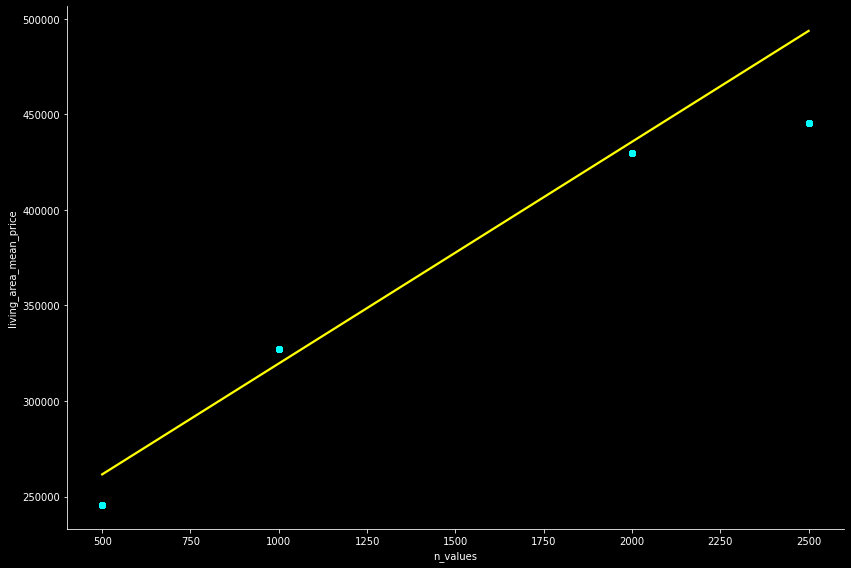

In [99]:
conditions = [(listings_df['living_area'] >= 500) & (listings_df['living_area'] < 1000), (listings_df['living_area'] >= 1000) & (listings_df['living_area'] < 2000), (listings_df['living_area'] >= 2000) & (listings_df['living_area'] < 2500), listings_df['living_area'] >= 2500]
values = ['500-1000 sq.ft', '1000-2000 sq.ft', '2000-2500 sq.ft', '>2500 sq.ft']
n_values = [500, 1000, 2000, 2500]
listings_df['living_area_range'] = np.select(conditions, values, default=0)
listings_df['n_values'] = np.select(conditions, n_values, default=0)

listings_df['living_area_mean_price'] = 0

for y in values:
    listings_df.loc[listings_df['living_area_range'] == y, 'living_area_mean_price'] = listings_df[listings_df['living_area_range'] == y]['price'].mean()

s = sns.pairplot(data=listings_df, x_vars='n_values', y_vars='living_area_mean_price', kind="reg", height=8, aspect=1.5, plot_kws=get_plot_kws('cyan', 'yellow'))
s.set(xticks=values, yticks=range(100000, 400000, 50000))